In [22]:
import csv
import pandas as pd
import matplotlib.pyplot as plt
import ast
import numpy as np
import seaborn as sns
import re
from bs4 import BeautifulSoup
import urllib
import requests
from urllib.request import urlopen
import json
from datetime import datetime as dt
import plotly.express as px

%matplotlib inline

!pip install folium

import folium
from folium import plugins

#### Yelp's Growing Popularity

We want to explore Yelp's growth by the amount of reviews. This tells us a lot about the company's growth because it demonstrates how much traffic the company is getting. We'll also explore the activities of its users. Are customers only posting reviews once or are frequent reviewers?

In our analysis below, we'll use a time series analysis to see the count of reviews over time. Additionally, we'll delve into the data set even further by examining the time of year of when user reviews are most active. This would provide us insight on whether user engagement is seasonal. 

In [23]:
#Due to the file's large size, we have to break it into chunks

review = pd.read_json("review.json", lines=True, chunksize= 1000000)
for r in review:
    review_subset = r
    break

In [24]:
#create date columns

review_subset.sort_values(by=['date'], ascending = False)

review_subset['day'] = review_subset['date'].dt.day_name()
review_subset['week'] = review_subset['date'].dt.week
review_subset['month'] = review_subset['date'].dt.month
review_subset['year'] = review_subset['date'].dt.year
review_subset['week-year'] = review_subset['date'].dt.strftime('%Y-%U')
review_subset['month-year'] = review_subset['date'].dt.strftime('%Y-%m')

In [25]:
#year Breakdown

year = review_subset[['month-year','review_id']]
year_group = year.groupby('month-year',as_index=False).count()
year_group['month-year']= pd.to_datetime(year_group['month-year'])

#Remove Incomplete Months
year_group = year_group[:-3]

In [26]:
#Month Breakdown

month = review_subset[['month','review_id']]
month_group = month.groupby('month',as_index=False).count()

In [27]:
#Day Breakdown

day_group = review_subset.groupby('day').size().reset_index(name='count')
day_group.set_index('day',inplace=True)
day_group = day_group.loc[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday','Sunday'], :]
day_group.reset_index(drop=False,inplace=True)

In [28]:
#Time Series Visualiztion - Explores Yelp's Growth

fig = px.line(year_group, 
              x='month-year', 
              y="review_id")

fig.update_layout(xaxis_title= "Year",
                  yaxis_title='Number of Reviews',
                  title={
                      'text': "Yelp's Growth",
                      'y':.95,
                      'x':0.5,
                      'xanchor': 'center',
                      'yanchor': 'top'},
                 xaxis_rangeslider_visible=True)
fig.show()

In [29]:
#Explore seasonality

fig = px.line(month_group, 
              x='month', 
              y='review_id')

fig.update_layout(xaxis_title= "Month",
                  yaxis_title='Number of Reviews',
                  title={
                      'text': "Number of Reviews Over Months",
                      'y':.95,
                      'x':0.5,
                      'xanchor': 'center',
                      'yanchor': 'top'})

fig.show()

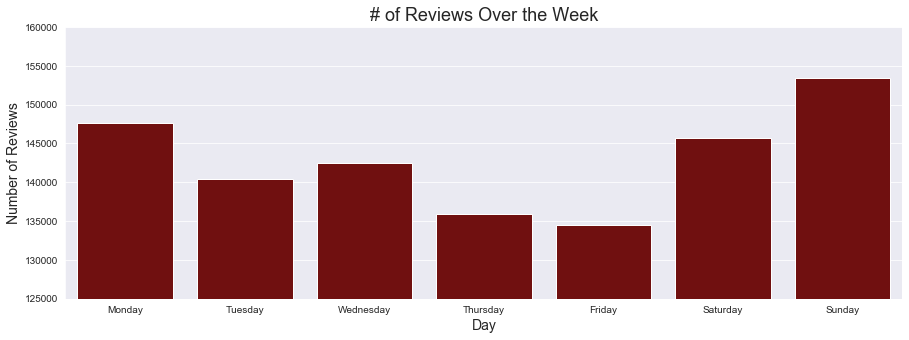

In [30]:
#Explore Number of reviews over the week

fig= plt.figure(figsize=(15,5))

sns.set_style("darkgrid")

ax = sns.barplot(x="day", y="count", data=day_group,color='maroon')

plt.xlabel('Day', fontsize=14)
plt.ylabel('Number of Reviews', fontsize=14)


plt.ylim(125000,160000)
plt.title('# of Reviews Over the Week', fontsize = 18)
plt.show()

## Business

With over 190,000 businesses in the Yelp Business Dataset, we narrowed it down to cities that have greater than 1000 restaurants. With these cities, we created another dataset that breaks the city population by its demographic. We would use this dataset to see how cities are tailoring the type of restaurants to its diversity.

In [31]:
#Open Business Dataset

business = pd.read_csv("business_full.csv")

#Extract relevant columns

business = business[['business_id','stars', 'categories', 'city']]

In [32]:
# Allows us to filter out null values and exclude all values that are not restaurants

business.head()
business[business['categories'].isna()].head()
business['categories'].replace('NaN','No reviews',inplace = True)
business.categories.fillna('No reviews',inplace = True)

In [33]:
#Filter dataset to include only restaurants 

business['Restaurants'] = business['categories'].str.contains('Restaurants')
business = business[business['Restaurants']==True]
business = business.drop(['Restaurants'],axis=1)

In [34]:
#Filter dataset to top cities

business['city'] = business['city'].replace({'North Las Vegas':'Las Vegas','MontrÃ©al':'Montreal'})

city_count = business.groupby('city')['business_id'].nunique()
city_count_db = pd.DataFrame({'city':city_count.index,'number of businesses':city_count.values})
city_count_db.head(5)

majority_city_count = city_count_db[city_count_db['number of businesses']>1000]
majority_city_count = majority_city_count.sort_values(by='number of businesses', ascending = False)
majority_city_count.rename(columns={'number of businesses':'number of restaurants'})

,city,number of restaurants
702,Toronto,7964
303,Las Vegas,6801
511,Phoenix,3999
404,Montreal,3846
87,Calgary,2912
109,Charlotte,2710
520,Pittsburgh,2453
629,Scottsdale,1573
122,Cleveland,1495
391,Mississauga,1447


In [39]:
#Turn City column to list
top_city = majority_city_count['city'].tolist()

#Dataframe data that breaks top cities by etnicity

white = [47.8, 47.9, 46.5, 74.5, 57.6, 45.1, 66.8, 81.0, 33.4, 42.3, 61.3, 74.5, 57.7]
indian = [16.8, 0.4, 0.8, 2.1, 9.5,	2.1, 1.3, 1.3, 0.4,	23.2, 0.4, 1.6, 2.4]
chinese = [10.8, 0.7, 0.4, 2.2, 8.3, 0.7, 1.9, 0.9, 0.7, 7.6, 0.4, 2.4, 2.6]
african_american = [7.5, 11.1, 6.5, 6.8, 4.6, 35.0, 24.6, 1.6, 53.3, 6.6, 3.7, 6.4, 6.2]
filipino = [4.3, 3.3, 0.5, 0.8, 5.9, 0.2, 0.1, 0.5, 0.2, 5.1, 0.2, 0.2, 0.6]
latin_american = [2.3, 31.5, 40.8, 2.7, 2.7, 13.1, 2.7, 10.3, 10.0, 2.3, 28.3, 7.0, 22.7]
southeast_asian=[1.4, 0.4, 0.7, 1.4, 1.8, 1.0, 0.3, 0.2, 0.2, 2.1, 0.4, 0.3, 0.7]
korean = [1.2, 0.5, 0.5, 0.2, 0.9, 0.3, 0.5, 0.4, 0.0, 0.9, 0.2, 0.9, 0.4]
japanese = [0.4, 0.4, 0.2, 0.1, 0.6, 0.1, 0.2, 0.3, 0.0, 0.3, 0.0, 0.2, 0.4]
other = [7.5, 3.8, 3.1, 9.2, 8.1, 2.4, 1.6, 3.5, 1.8, 9.6, 5.1, 6.5, 6.3]

In [40]:
#Create dataframe

racial_breakdown_db = {'City': top_city,
                   'White': white,
                   'Indian': indian,
                    'Chinese':chinese,
                    'African American': african_american,
                    'Filipino' : filipino,
                    'Latin' :latin_american,
                    'Southeast Asian': southeast_asian,
                    'Korean' : korean,
                    'Japanese' : japanese,
                    'Other' : other}

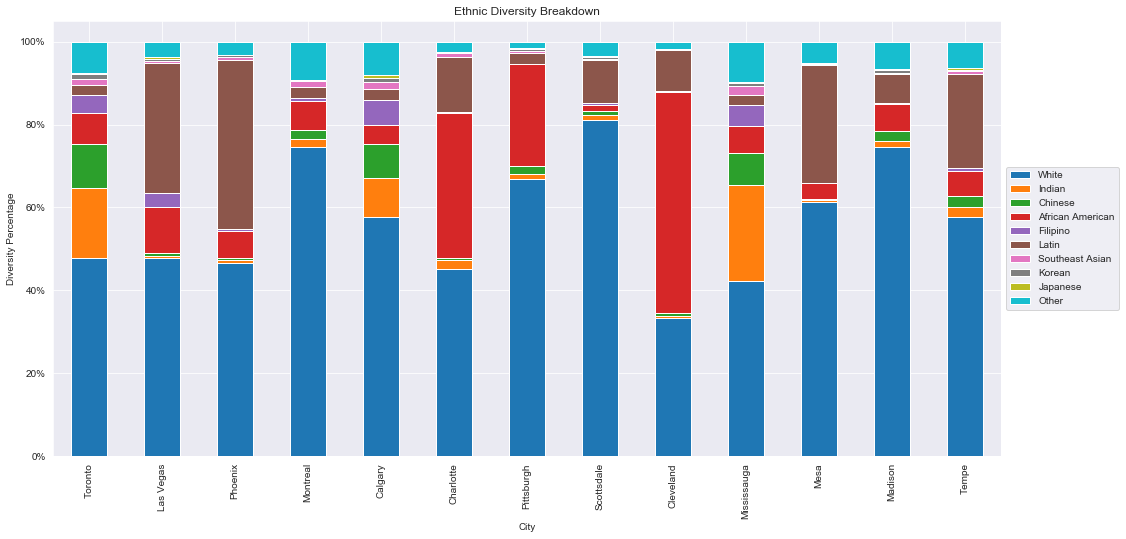

In [42]:
#Barchart to visualize diversity in top cities in db

racial_breakdown_db = pd.DataFrame.from_dict(racial_breakdown)
racial_breakdown_db = racial_breakdown_db.set_index('City')


racial_breakdown_db.plot.bar(stacked=True, figsize = (17,8))
plt.xlabel('City')
plt.ylabel('Diversity Percentage')
plt.title('Ethnic Diversity Breakdown')
plt.yticks([0,20,40,60,80,100],['0%','20%','40%','60%','80%','100%'])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [43]:
#Filter to observed cities
biz_filter = business[business['city'].isin(top_city)]

# Breaking Up Businesses Into Own Category
ind_db = biz_filter.copy(deep=True)
chi_db = biz_filter.copy(deep=True)
aa_db = biz_filter.copy(deep=True)
filipino_db = biz_filter.copy(deep=True)
lat_db = biz_filter.copy(deep=True)
sea_db = biz_filter.copy(deep=True)
kor_db = biz_filter.copy(deep=True)
japa_db = business.copy(deep=True)

ind_db['Indian'] = ind_db['categories'].str.contains('Indian')
ind_db = ind_db[ind_db['Indian']==True]
ind_db = ind_db.drop(['Indian'],axis=1)

chi_db['Chinese'] = chi_db['categories'].str.contains('Chinese')
chi_db = chi_db[chi_db['Chinese']==True]
chi_db = chi_db.drop(['Chinese'],axis=1)

aa_db['African_American'] = aa_db['categories'].str.contains('Soul Food | Southern | Comfort Food | Cajun/Creole')
aa_db = aa_db[aa_db['African_American']==True]
aa_db = aa_db.drop(['African_American'],axis=1)

filipino_db['Filipino'] = filipino_db['categories'].str.contains('Filipino')
filipino_db = filipino_db[filipino_db['Filipino']==True]
filipino_db = filipino_db.drop(['Filipino'],axis=1)

lat_db['Latin'] = lat_db['categories'].str.contains('Mexican | Latin | Spanish | Portuguese | Cuban')
lat_db = lat_db[lat_db['Latin']==True]
lat_db = lat_db.drop(['Latin'],axis=1)

sea_db['SE Asian'] = sea_db['categories'].str.contains('Indonesian | Vietnamese | Cambodian |Thai | Burmese | Laotian')
sea_db = sea_db[sea_db['SE Asian']==True]
sea_db = sea_db.drop(['SE Asian'],axis=1)

kor_db['Korean'] = kor_db['categories'].str.contains('Korean')
kor_db = kor_db[kor_db['Korean']==True]
kor_db = kor_db.drop(['Korean'],axis=1)

japa_db['Japanese'] = japa_db['categories'].str.contains('Japanese')
japa_db = japa_db[japa_db['Japanese']==True]
japa_db = japa_db.drop(['Japanese'],axis=1)

In [45]:
# Examine Indian Cuisine
ind_db.groupby(by = 'city')

ind_db_avg = ind_db.groupby('city')['stars'].mean().round(2)
ind_avg_pd = pd.DataFrame({'city':ind_db_avg.index,'average reviews': ind_db_avg.values})
ind_avg_pd

ind_db_count = ind_db.groupby('city')['business_id'].nunique()
ind_db_count = pd.DataFrame({'city':ind_db_count.index,'# of restaurants': ind_db_count.values})
ind_db_count

ind_res_overview = pd.merge(ind_avg_pd,ind_db_count, on = 'city')
ind_res_overview = ind_res_overview.rename({'city':'City'}, axis=1)


ind_final_db = pd.merge(ind_res_overview, racial_breakdown_db['Indian'], on= 'City')

In [46]:
# Examine Chinese Cuisine
chi_db.groupby(by = 'city')

chi_db_avg = chi_db.groupby('city')['stars'].mean().round(2)
chi_avg_pd = pd.DataFrame({'city':chi_db_avg.index,'average reviews': chi_db_avg.values})
chi_avg_pd

chi_db_count = chi_db.groupby('city')['business_id'].nunique()
chi_db_count = pd.DataFrame({'city':chi_db_count.index,'# of restaurants': chi_db_count.values})
chi_db_count

chi_res_overview = pd.merge(chi_avg_pd,chi_db_count, on = 'city')
chi_res_overview = chi_res_overview.rename({'city':'City'}, axis=1)


chi_final_db = pd.merge(chi_res_overview, racial_breakdown_db['Chinese'], on= 'City')

In [47]:
# Examine African American Cuisine
aa_db.groupby(by = 'city')

aa_db_avg = aa_db.groupby('city')['stars'].mean().round(2)
aa_avg_pd = pd.DataFrame({'city':aa_db_avg.index,'average reviews': aa_db_avg.values})
aa_avg_pd

aa_db_count = aa_db.groupby('city')['business_id'].nunique()
aa_db_count = pd.DataFrame({'city':aa_db_count.index,'# of restaurants': aa_db_count.values})
aa_db_count

aa_res_overview = pd.merge(aa_avg_pd,aa_db_count, on = 'city')
aa_res_overview = aa_res_overview.rename({'city':'City'}, axis=1)


aa_final_db = pd.merge(aa_res_overview, racial_breakdown_db['African American'], on= 'City')

In [48]:
# Examine Filipino Cuisine
filipino_db.groupby(by = 'city')

filipino_db_avg = filipino_db.groupby('city')['stars'].mean().round(2)
filipino_avg_pd = pd.DataFrame({'city':filipino_db_avg.index,'average reviews': filipino_db_avg.values})
filipino_avg_pd

filipino_db_count = filipino_db.groupby('city')['business_id'].nunique()
filipino_db_count = pd.DataFrame({'city':filipino_db_count.index,'# of restaurants': filipino_db_count.values})
filipino_db_count

filipino_res_overview = pd.merge(filipino_avg_pd,filipino_db_count, on = 'city')
filipino_res_overview = filipino_res_overview.rename({'city':'City'}, axis=1)


filipino_final_db = pd.merge(filipino_res_overview, racial_breakdown_db['Filipino'], on= 'City')

In [49]:
# Examine Latin Cuisine
lat_db.groupby(by = 'city')

lat_db_avg = lat_db.groupby('city')['stars'].mean().round(2)
lat_avg_pd = pd.DataFrame({'city':lat_db_avg.index,'average reviews': lat_db_avg.values})
lat_avg_pd

lat_db_count = lat_db.groupby('city')['business_id'].nunique()
lat_db_count = pd.DataFrame({'city':lat_db_count.index,'# of restaurants': lat_db_count.values})
lat_db_count

lat_res_overview = pd.merge(lat_avg_pd,lat_db_count, on = 'city')
lat_res_overview = lat_res_overview.rename({'city':'City'}, axis=1)


lat_final_db = pd.merge(lat_res_overview, racial_breakdown_db['Latin'], on= 'City')

In [50]:
# Examine Southeast Asian Cuisine
sea_db.groupby(by = 'city')

sea_db_avg = sea_db.groupby('city')['stars'].mean().round(2)
sea_avg_pd = pd.DataFrame({'city':sea_db_avg.index,'average reviews': sea_db_avg.values})
sea_avg_pd

sea_db_count = sea_db.groupby('city')['business_id'].nunique()
sea_db_count = pd.DataFrame({'city':sea_db_count.index,'# of restaurants': sea_db_count.values})
sea_db_count

sea_res_overview = pd.merge(sea_avg_pd,sea_db_count, on = 'city')
sea_res_overview = sea_res_overview.rename({'city':'City'}, axis=1)


sea_final_db = pd.merge(sea_res_overview, racial_breakdown_db['Southeast Asian'], on= 'City')

In [51]:
# Examine Korean Cuisine
kor_db.groupby(by = 'city')

kor_db_avg = kor_db.groupby('city')['stars'].mean().round(2)
kor_avg_pd = pd.DataFrame({'city':kor_db_avg.index,'average reviews': kor_db_avg.values})
kor_avg_pd

kor_db_count = kor_db.groupby('city')['business_id'].nunique()
kor_db_count = pd.DataFrame({'city':kor_db_count.index,'# of restaurants': kor_db_count.values})
kor_db_count

kor_res_overview = pd.merge(kor_avg_pd,kor_db_count, on = 'city')
kor_res_overview = kor_res_overview.rename({'city':'City'}, axis=1)


kor_final_db = pd.merge(kor_res_overview, racial_breakdown_db['Korean'], on= 'City')

In [52]:
# Examine Japanese Cuisine
japa_db.groupby(by = 'city')

japa_db_avg = japa_db.groupby('city')['stars'].mean().round(2)
japa_avg_pd = pd.DataFrame({'city':japa_db_avg.index,'average reviews': japa_db_avg.values})
japa_avg_pd

japa_db_count = japa_db.groupby('city')['business_id'].nunique()
japa_db_count = pd.DataFrame({'city':japa_db_count.index,'# of restaurants': japa_db_count.values})
japa_db_count

japa_res_overview = pd.merge(japa_avg_pd,japa_db_count, on = 'city')
japa_res_overview = japa_res_overview.rename({'city':'City'}, axis=1)


japa_final_db = pd.merge(japa_res_overview, racial_breakdown_db['Japanese'], on= 'City')

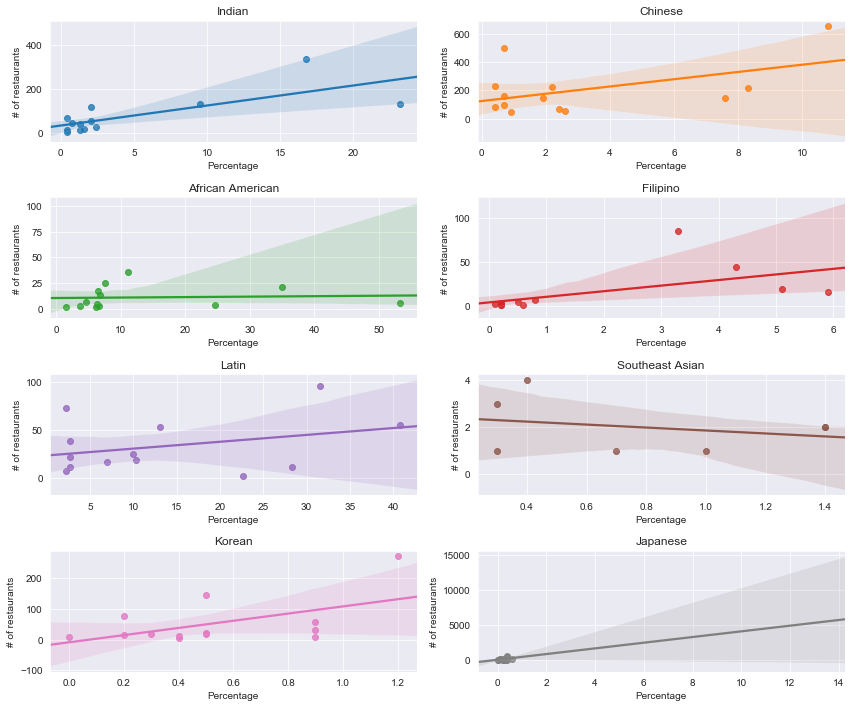

In [53]:
#Scatterplot to visualize number of ethnic restaurants by cities' percentage of corresponding ethnicity

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4,2,figsize=(12,10))


sns.set()

sns.regplot(x='Indian',y='# of restaurants', data= ind_final_db, ax=ax1)
sns.regplot(x='Chinese',y='# of restaurants', data= chi_final_db, ax=ax2)
sns.regplot(x='African American',y='# of restaurants', data=aa_final_db, ax=ax3)
sns.regplot(x='Filipino',y='# of restaurants', data= filipino_final_db, ax=ax4)
sns.regplot(x='Latin',y='# of restaurants', data= lat_final_db, ax=ax5)
sns.regplot(x='Southeast Asian',y='# of restaurants', data= sea_final_db, ax=ax6)
sns.regplot(x='Korean',y='# of restaurants', data= kor_final_db, ax=ax7)
sns.regplot(x='Japanese',y='# of restaurants', data= japa_final_db, ax=ax8)


ax1.set(title='Indian',xlabel='Percentage')
ax2.set(title='Chinese',xlabel='Percentage')
ax3.set(title='African American',xlabel='Percentage')
ax4.set(title='Filipino',xlabel='Percentage')
ax5.set(title='Latin',xlabel='Percentage')
ax6.set(title='Southeast Asian',xlabel='Percentage')
ax7.set(title='Korean',xlabel='Percentage')
ax8.set(title='Japanese',xlabel='Percentage')

fig.tight_layout()

#### Nevada GeoSpatial Breakdown

With the longitute and latitude colunmn, we created a heatmap that visualize the number of restaurants over the state of Nevada. We can use this map to see how cities place their restaurants

In [54]:
business = pd.read_csv("business_full.csv")

#Extract columns for our heat map
biz_db = review_subset[['business_id','review_id','stars','date','year']]


#Merge Review and Business Dataset
new_biz_db = biz_db.merge(business,on='business_id')
new_biz_db

,business_id,review_id,stars_x,date,year,Unnamed: 0,name,address,city,state,postal_code,latitude,longitude,stars_y,review_count,is_open,attributes,categories,hours
0,ujmEBvifdJM6h6RLv4wQIg,Q1sbwvVQXV2734tPgoKj4Q,1,2013-05-07 04:34:36,2013,13128,MountainView Hospital,3100 N Tenaya Way,Las Vegas,NV,89128,36.215546,-115.248798,2.5,238,1,"{'ByAppointmentOnly': 'False', 'GoodForKids': ...","Fitness & Instruction, Doctors, Health & Medic...","{'Monday': '0:0-0:0', 'Tuesday': '0:0-0:0', 'W..."
1,ujmEBvifdJM6h6RLv4wQIg,8Edv5pKe5lOBoN5UZTUI1w,4,2017-02-09 06:45:18,2017,13128,MountainView Hospital,3100 N Tenaya Way,Las Vegas,NV,89128,36.215546,-115.248798,2.5,238,1,"{'ByAppointmentOnly': 'False', 'GoodForKids': ...","Fitness & Instruction, Doctors, Health & Medic...","{'Monday': '0:0-0:0', 'Tuesday': '0:0-0:0', 'W..."
2,ujmEBvifdJM6h6RLv4wQIg,kEs5u0cGPtiSQCLW7b0l9g,1,2018-08-14 05:25:33,2018,13128,MountainView Hospital,3100 N Tenaya Way,Las Vegas,NV,89128,36.215546,-115.248798,2.5,238,1,"{'ByAppointmentOnly': 'False', 'GoodForKids': ...","Fitness & Instruction, Doctors, Health & Medic...","{'Monday': '0:0-0:0', 'Tuesday': '0:0-0:0', 'W..."
3,ujmEBvifdJM6h6RLv4wQIg,Pm6qydbW58BB0zdWCPlBmg,1,2018-05-08 19:27:59,2018,13128,MountainView Hospital,3100 N Tenaya Way,Las Vegas,NV,89128,36.215546,-115.248798,2.5,238,1,"{'ByAppointmentOnly': 'False', 'GoodForKids': ...","Fitness & Instruction, Doctors, Health & Medic...","{'Monday': '0:0-0:0', 'Tuesday': '0:0-0:0', 'W..."
4,ujmEBvifdJM6h6RLv4wQIg,QWJVYwNxUY_Plu4Ipz33_A,5,2014-10-11 06:57:18,2014,13128,MountainView Hospital,3100 N Tenaya Way,Las Vegas,NV,89128,36.215546,-115.248798,2.5,238,1,"{'ByAppointmentOnly': 'False', 'GoodForKids': ...","Fitness & Instruction, Doctors, Health & Medic...","{'Monday': '0:0-0:0', 'Tuesday': '0:0-0:0', 'W..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,e2Qi9bccyC01TlQ1uqaXDw,-3THdtH5fg3ASOE1ENDKgw,5,2013-09-15 04:27:50,2013,33235,Animal Emergency Center,5152 Grove Ave,Lorain,OH,44055,41.422266,-82.119931,3.5,3,1,NaN,"Pets, Veterinarians","{'Monday': '18:0-0:0', 'Tuesday': '18:0-0:0', ..."
999996,hjt5WiDPsAQJo8-hH3F-IA,sQAFfdYSeN6mrkU45sfCig,5,2013-07-22 09:12:26,2013,23510,Dino's Barber Salon,2932 N 68th St,Scottsdale,AZ,85251,33.481441,-111.935106,5.0,4,0,"{'BusinessAcceptsCreditCards': 'True', 'Busine...","Beauty & Spas, Barbers",NaN
999997,IQDOSTF0NpeHlku6woaWLw,rdZ1ViTXPJnYxPC-jUBJHA,4,2015-04-24 05:34:18,2015,28317,Concentra Medical Centers,358 Junction Rd,Madison,WI,53717,43.067350,-89.525408,2.0,4,1,{'ByAppointmentOnly': 'False'},"Doctors, Health & Medical",NaN
999998,lxl0KqBMi04BH2HdWyqzpg,lkYX4ZNwS784MZ5HXNPuLQ,1,2016-03-12 04:24:26,2016,24868,Blyth Academy,3284 Yonge Street,Toronto,ON,M4N 3M7,43.730359,-79.403921,1.0,3,1,NaN,"Middle Schools & High Schools, Educational Ser...",NaN


In [55]:
#Filter to only Nevada data
nv = new_biz_db.loc[new_biz_db['state'] == 'NV']

In [56]:
nv['city'].unique()

array(['Las Vegas', 'Henderson', 'North Las Vegas', 'Boulder City',
       'Las vegas', 'N. Las Vegas', 'Nellis AFB', 'Blue Diamond',
       'las Vegas', 'LAS VEGAS', 'North Las Vegas ', 'las vegas',
       'La Vegas', 'Summerlin', 'South Las Vegas', 'HENDERSON',
       'City Center', 'henderson', 'Paradise', 'Las Vegass',
       'N Las Vegas', 'Hendserson', 'Enterprise'], dtype=object)

In [57]:
#Clean City Data
nv['city'] = nv['city'].str.replace(r'.*(L|l).*(V|v).*', 'Las Vegas')
nv['city'] = nv['city'].str.replace(r'(Hend|hend|HEND).*', 'Henderson')

C:\Users\kevin\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\kevin\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [58]:
#Remove incorrect postal codes
nv = nv[~nv['postal_code'].isin([10300,71863])]

In [59]:
#Create Heatmap Data
hm = nv.groupby(['latitude','longitude']).size().reset_index(name='count').sort_values(by='count',ascending=False)

In [60]:
from folium.plugins import HeatMap

In [61]:
#Create Heatmap
nv_map =folium.Map([36.1699, -115.1398],zoom_start=10)
HeatMap(data=hm, radius=8, max_zoom=13).add_to(nv_map)

In [62]:
nv_map